<a href="https://colab.research.google.com/github/wangbcbill/Deep-Learning/blob/master/MNIST_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We implemented VAE using MNIST. 

In [0]:
import os
import scipy.misc
import numpy as np
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt

def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), tf.shape(conv))
        return conv

def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="deconv2d"):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))
        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), tf.shape(deconv))
        return deconv

def batch_norm(input, epsilon=1e-5, momentum=0.9, train=True, name="batch_norm"):
    return tf.contrib.layers.batch_norm(input, decay=momentum, updates_collections=None,
            epsilon=epsilon, scale=True, is_training=train, scope=name)

def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

def img2cell(images, col_num=25, margin=2):
    [num_images, size_h, size_w, n_channel] = images.shape
    row_num = int(math.ceil(num_images/col_num))
    saved_img = np.zeros(((row_num * size_h + margin * (row_num - 1)),
                          (col_num * size_w + margin * (col_num - 1)),
                          n_channel), dtype=np.float32)
    for idx in range(num_images):
        ir = int(math.floor(idx / col_num))
        ic = idx % col_num
        saved_img[(size_h + margin) * ir:size_h + (size_h + margin) * ir,
        (size_w + margin) * ic:size_w + (size_w + margin) * ic, :] = images[idx]
    return saved_img.squeeze()


In [0]:
class VAE(object):
    def __init__(self, sess, image_size=28,
                 batch_size=100, sample_size=100, z_dim=5, c_dim=1, GPU=True):
        """

        Args:
            sess: TensorFlow session
            image_size: The size of input image.
            batch_size: The size of batch. Should be specified before training.
            sample_size: (optional) The size of sampling. Should be specified before training.
            output_size: (optional) The resolution in pixels of the images. [28]
            z_dim: (optional) Dimension of latent vectors. [5]
            c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [1]
        """
        self.sess = sess
        self.batch_size = batch_size
        self.input_size = image_size
        self.sample_size = sample_size
        self.output_size = image_size
        self.print_step = 1

        self.z_dim = z_dim
        self.c_dim = 1

        self.dataset_name = 'mnist'
        
        self.GPU = GPU
      
        
        if self.GPU:
            device_name = '/gpu:0'
        else:
            device_name = '/cpu:0'
        
        with tf.device(device_name):
            self.build_model()
        

    def encoder(self, image, z_dim, reuse=False, train=True):
        with tf.variable_scope("encoder", reuse=reuse):
            #######################################################
            # The output of encoder network should have two parts:
            # A mean vector and a log(std) vector. Both of them have
            # the same dimension with latent vector z.
            #######################################################

            l1 = lrelu(batch_norm(conv2d(image, 32, name="layer1"), train=train, name="bn1"))
            
            l2 = lrelu(batch_norm(conv2d(l1, 64, name="layer2"), train=train, name="bn2"))
            
            l3 = lrelu(batch_norm(conv2d(l2, 64, d_h=1, d_w=1, name="layer3"), train=train, name="bn3"))
            
            mean = linear(tf.contrib.layers.flatten(l3),
                                     z_dim, scope="mean")
                              
            log_std = linear(tf.contrib.layers.flatten(l3),
                                     z_dim, scope="std")
                              
                              
            
            return mean, log_std
            


    def decoder(self, z, reuse=False, train=True):
        with tf.variable_scope("decoder", reuse=reuse):
          
            
            l5 = lrelu(batch_norm(tf.reshape(linear(z, 7*7*64, scope="layer5"), [-1, 7, 7, 64]),train=train, name="bn4"))
            
            l6 = lrelu(batch_norm(deconv2d(l5, [tf.shape(z)[0], 7, 7, 32], d_h=1, d_w=1, 
                                          name="layer6"), train=train, name="bn5"))
            
            l7 = lrelu(batch_norm(deconv2d(l6, [tf.shape(z)[0], 14, 14, 32], name="layer7"), train=train, name="bn6"))
            
            g = deconv2d(l7, [tf.shape(z)[0], 28, 28, 1], name="layer8")
            
            
            
            return tf.nn.sigmoid(g)
            

    def build_model(self):
        #######################################################
        # Loss term has two parts: reconstruction loss and KL 
        # divergence loss. Save the loss as self.loss. Use the
        # reparameterization trick to sample z.
        #######################################################

        # variables : input
        self.x = tf.placeholder(tf.float32, shape=(None, self.input_size, self.input_size, self.c_dim))
        self.z_sample = tf.placeholder(tf.float32, shape=(None, self.z_dim), name='latent_variable')
        self.isTrain = tf.placeholder(dtype=tf.bool)

        # networks :
        
        self.z_mean, self.z_std = self.encoder(self.x, self.z_dim)
        
        self.z_sample = self.z_mean + tf.exp(self.z_std)*tf.random.normal([tf.shape(self.x)[0],self.z_dim], dtype=tf.float32)
        
        self.recon = self.decoder(self.z_sample)
        
        x =  tf.reshape(self.x, [self.batch_size, -1])
        
        recon =  tf.reshape(self.recon, [self.batch_size, -1])
        
        self.loglik = tf.reduce_mean(tf.reduce_sum(-(x * tf.log(recon + 1e-12) + (1. - x) * tf.log(1. - recon + 1e-12)),1))
        
        self.kl_divergence = tf.reduce_mean(- 0.5 * tf.reduce_sum(1. + self.z_std - tf.square(self.z_mean) - tf.exp(self.z_std),1))
        
        self.loss = self.loglik + self.kl_divergence



    def train(self, num_epoch=25, lr=0.0002, beta1=0.5, is_crop=False, visualize=True):
        """Train VAE"""
        # load MNIST dataset
        mnist = tf.keras.datasets.mnist
        (data, _), (_,_) = mnist.load_data()
        data = np.reshape(data, [-1, 28, 28, 1]).astype(np.float32) / 255
        data_len = data.shape[0]
        optim = tf.train.AdamOptimizer(lr, beta1=beta1).minimize(self.loss)
        try:
            self.sess.run(tf.global_variables_initializer())
        except:
            tf.initialize_all_variables().run()
        t_vars = tf.trainable_variables()

        start_time = time.time()
        counter = 1
        train_hist = {}
        train_hist['losses_L'] = []
        train_hist['losses_KL'] = []
        
        z_sample = np.random.normal(0, 1, size=[self.sample_size, self.z_dim])
        output_image = img2cell(data[0:100, ...])
        print("Original Image: ")
        plt.imshow(output_image)
        plt.axis('off')
        plt.show()
            
        for epoch in range(num_epoch):
            
            batch_idxs = data_len // self.batch_size
            batch_total_loss = batch_loss_likelihood = batch_loss_divergence = 0
            epoch_start_time = time.time()
            
            for idx in range(0, batch_idxs):
                counter += 1
                batch_images = data[idx*self.batch_size:(idx+1)*self.batch_size, :]
                #######################################################
                # Train model and print the loss term at to monitor 
                # the training process. Print reconstructed images and 
                # sample images every self.print_step steps. Sample z 
                # from standard normal distribution for sampling images. 
                #######################################################
               
                _, loss, recon, loglik, kl_divergence = self.sess.run([optim, self.loss, self.recon, self.loglik, self.kl_divergence], feed_dict={self.x: batch_images})

                batch_loss_likelihood += loglik
                batch_loss_divergence += kl_divergence
                batch_total_loss += loss
                

            if epoch % self.print_step == 0:
                sample_image = self.sess.run(self.recon, {self.z_sample: z_sample})
                output_image = img2cell(sample_image)
                print("Epoch %d : Sampling Image: " % epoch)
                plt.imshow(output_image)
                plt.axis('off')
                plt.show()
                recons_image = self.sess.run(self.recon, {self.x: data[0:100, ...], self.isTrain: False})
                output_image = img2cell(recons_image)
                print("Epoch %d : Reconstruct Image: " % epoch)
                plt.imshow(output_image)
                plt.axis('off')
                plt.show()

            epoch_end_time = time.time()
            batch_total_loss /= batch_idxs
            batch_loss_likelihood /= batch_idxs
            batch_loss_divergence /= batch_idxs
            per_epoch_ptime = epoch_end_time - epoch_start_time
            print('[%d/%d] - ptime: %.2f Total_loss=(L+KL): %.3f = (%.3f+%.3f)' 
                  % ((epoch + 1), num_epoch, per_epoch_ptime, batch_total_loss, batch_loss_likelihood, batch_loss_divergence))
            train_hist['losses_L'].append(batch_loss_likelihood)
            train_hist['losses_KL'].append(batch_loss_divergence)
        plt.plot(train_hist['losses_L'])
        plt.plot(train_hist['losses_KL'])
        plt.show()

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.cast instead.
Original Image: 


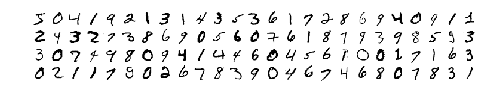

Epoch 0 : Sampling Image: 


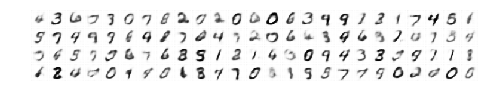

Epoch 0 : Reconstruct Image: 


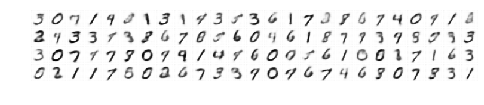

[1/25] - ptime: 11.27 Total_loss=(L+KL): 199.924 = (194.417+5.507)
Epoch 1 : Sampling Image: 


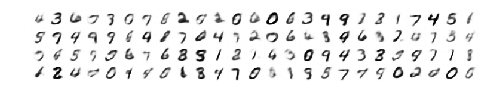

Epoch 1 : Reconstruct Image: 


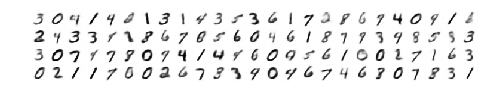

[2/25] - ptime: 9.90 Total_loss=(L+KL): 132.664 = (126.271+6.393)
Epoch 2 : Sampling Image: 


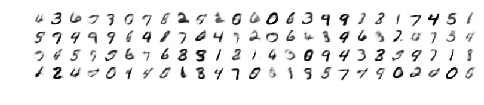

Epoch 2 : Reconstruct Image: 


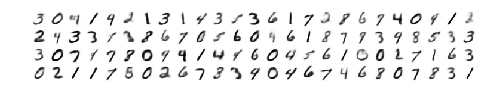

[3/25] - ptime: 9.89 Total_loss=(L+KL): 126.397 = (119.798+6.598)
Epoch 3 : Sampling Image: 


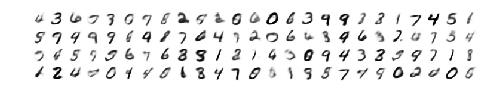

Epoch 3 : Reconstruct Image: 


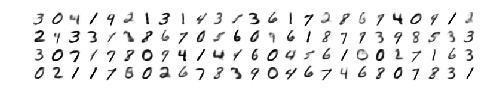

[4/25] - ptime: 9.86 Total_loss=(L+KL): 123.579 = (116.879+6.700)
Epoch 4 : Sampling Image: 


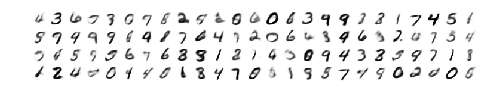

Epoch 4 : Reconstruct Image: 


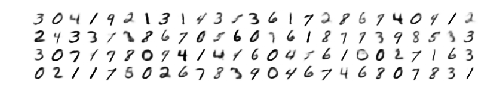

[5/25] - ptime: 9.69 Total_loss=(L+KL): 121.801 = (115.048+6.752)
Epoch 5 : Sampling Image: 


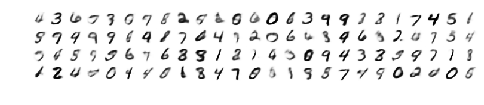

Epoch 5 : Reconstruct Image: 


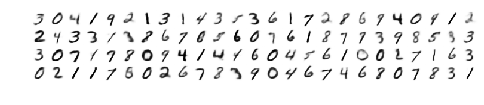

[6/25] - ptime: 9.86 Total_loss=(L+KL): 120.482 = (113.668+6.814)
Epoch 6 : Sampling Image: 


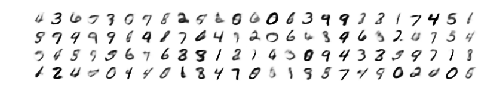

Epoch 6 : Reconstruct Image: 


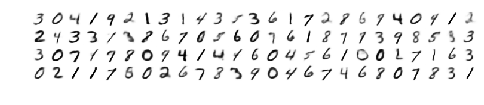

[7/25] - ptime: 9.91 Total_loss=(L+KL): 119.451 = (112.594+6.857)
Epoch 7 : Sampling Image: 


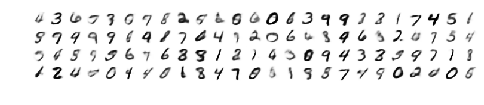

Epoch 7 : Reconstruct Image: 


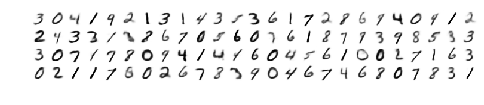

[8/25] - ptime: 9.85 Total_loss=(L+KL): 118.629 = (111.750+6.880)
Epoch 8 : Sampling Image: 


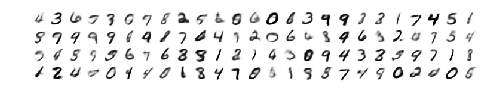

Epoch 8 : Reconstruct Image: 


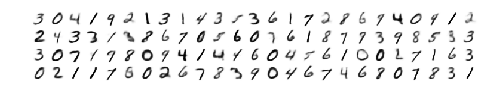

[9/25] - ptime: 9.83 Total_loss=(L+KL): 117.829 = (110.928+6.901)
Epoch 9 : Sampling Image: 


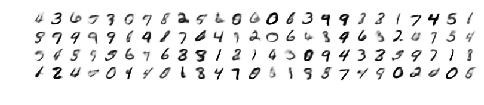

Epoch 9 : Reconstruct Image: 


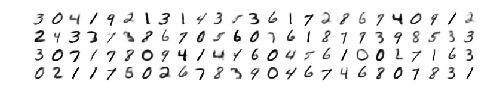

[10/25] - ptime: 9.89 Total_loss=(L+KL): 117.260 = (110.341+6.919)
Epoch 10 : Sampling Image: 


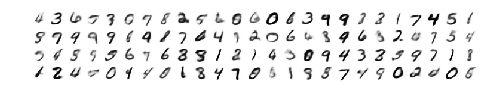

Epoch 10 : Reconstruct Image: 


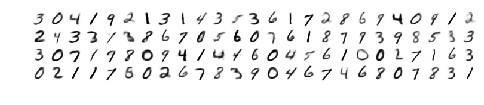

[11/25] - ptime: 9.88 Total_loss=(L+KL): 116.581 = (109.649+6.931)
Epoch 11 : Sampling Image: 


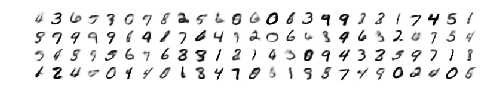

Epoch 11 : Reconstruct Image: 


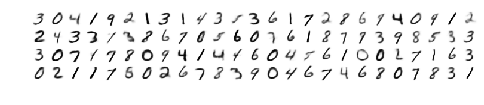

[12/25] - ptime: 9.86 Total_loss=(L+KL): 116.151 = (109.192+6.959)
Epoch 12 : Sampling Image: 


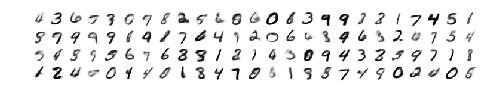

Epoch 12 : Reconstruct Image: 


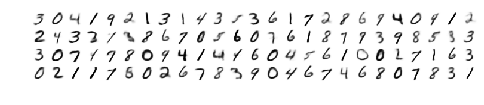

[13/25] - ptime: 9.88 Total_loss=(L+KL): 115.626 = (108.657+6.969)
Epoch 13 : Sampling Image: 


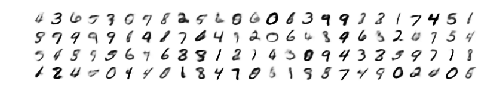

Epoch 13 : Reconstruct Image: 


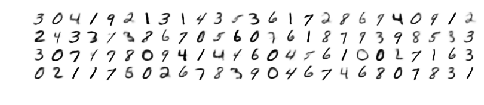

[14/25] - ptime: 9.87 Total_loss=(L+KL): 115.224 = (108.223+7.001)
Epoch 14 : Sampling Image: 


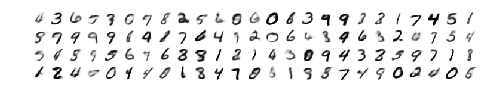

Epoch 14 : Reconstruct Image: 


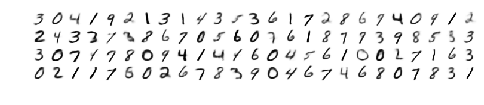

[15/25] - ptime: 9.88 Total_loss=(L+KL): 114.736 = (107.733+7.003)
Epoch 15 : Sampling Image: 


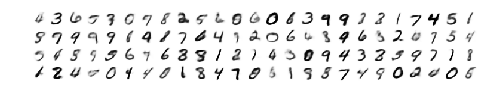

Epoch 15 : Reconstruct Image: 


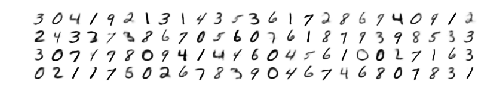

[16/25] - ptime: 10.09 Total_loss=(L+KL): 114.306 = (107.302+7.005)
Epoch 16 : Sampling Image: 


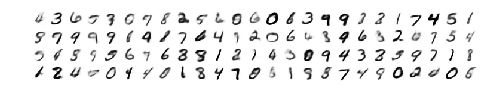

Epoch 16 : Reconstruct Image: 


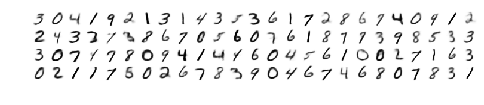

[17/25] - ptime: 9.89 Total_loss=(L+KL): 113.977 = (106.955+7.022)
Epoch 17 : Sampling Image: 


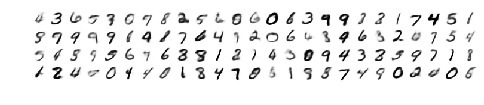

Epoch 17 : Reconstruct Image: 


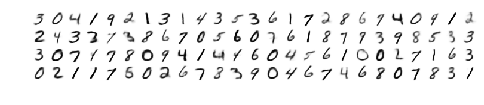

[18/25] - ptime: 9.86 Total_loss=(L+KL): 113.602 = (106.568+7.035)
Epoch 18 : Sampling Image: 


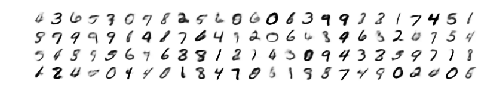

Epoch 18 : Reconstruct Image: 


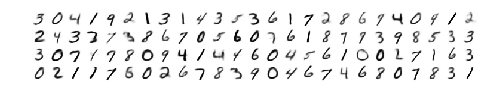

[19/25] - ptime: 9.90 Total_loss=(L+KL): 113.277 = (106.236+7.041)
Epoch 19 : Sampling Image: 


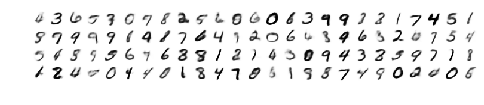

Epoch 19 : Reconstruct Image: 


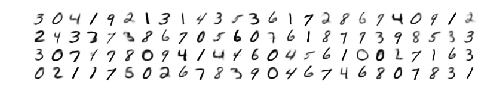

[20/25] - ptime: 9.89 Total_loss=(L+KL): 112.952 = (105.898+7.054)
Epoch 20 : Sampling Image: 


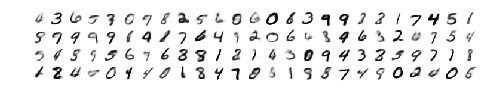

Epoch 20 : Reconstruct Image: 


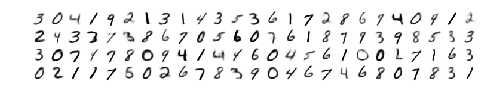

[21/25] - ptime: 9.89 Total_loss=(L+KL): 112.717 = (105.653+7.064)
Epoch 21 : Sampling Image: 


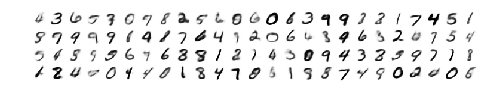

Epoch 21 : Reconstruct Image: 


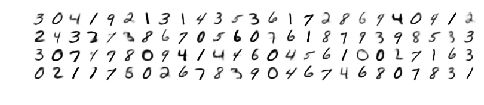

[22/25] - ptime: 9.90 Total_loss=(L+KL): 112.355 = (105.291+7.065)
Epoch 22 : Sampling Image: 


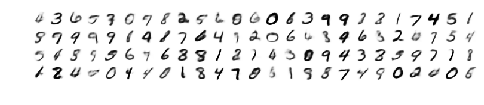

Epoch 22 : Reconstruct Image: 


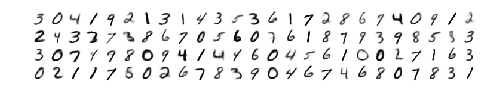

[23/25] - ptime: 9.90 Total_loss=(L+KL): 112.091 = (105.034+7.057)
Epoch 23 : Sampling Image: 


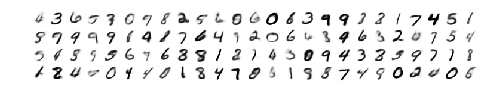

Epoch 23 : Reconstruct Image: 


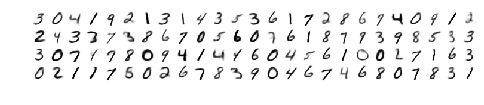

[24/25] - ptime: 9.89 Total_loss=(L+KL): 111.831 = (104.763+7.068)
Epoch 24 : Sampling Image: 


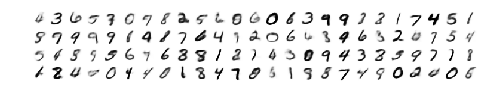

Epoch 24 : Reconstruct Image: 


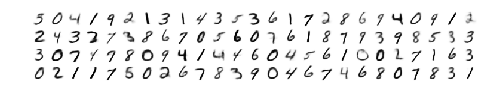

[25/25] - ptime: 9.87 Total_loss=(L+KL): 111.621 = (104.542+7.079)


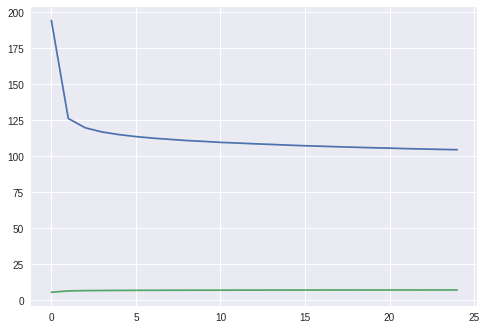

In [0]:
with tf.Session() as sess:
    vae = VAE(sess, image_size=28, batch_size=100, z_dim=5)
    vae.train(num_epoch=25, lr=0.0002, beta1=0.5)